<a href="https://colab.research.google.com/github/NMengo/ML-Practice/blob/main/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skimage


In [161]:
from skimage import data, color
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import try_all_threshold, threshold_otsu, threshold_local, sobel, gaussian
from skimage import exposure, morphology
from skimage.transform import rotate, rescale, resize
from skimage.restoration import inpaint

In [75]:
def show_image(image, cmap=None, size=(10,5)):
  plt.figure(figsize=size)
  plt.imshow(image, cmap=cmap)
  plt.axis('off')
  plt.show()

In [190]:
def plot_comparison(*images, titles, size=(20,10)):
  axs = tuple(['ax'+str(n) for n in range(len(images))])
  fig, axs = plt.subplots(ncols=len(images), figsize=size, sharex=True, sharey=True)
  for ax, img, title in zip(axs, images, titles):
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_title(title)
    ax.axis('off')


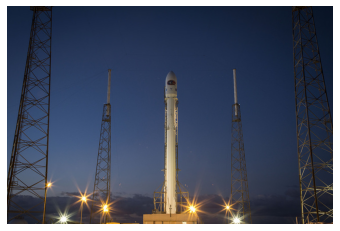

In [12]:
rocket = data.rocket()
show_image(rocket)

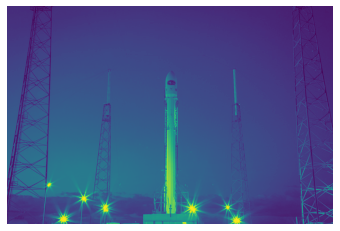

In [26]:
grey_rocket = color.rgb2gray(rocket)
show_image(grey_rocket)

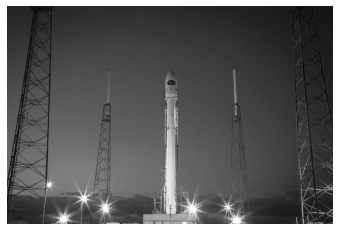

In [34]:
show_image(grey_rocket, cmap='Greys_r')

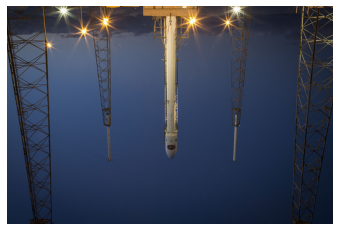

In [36]:
# Flip the image vertically
vflip_rocket = np.flipud(rocket)
show_image(vflip_rocket)

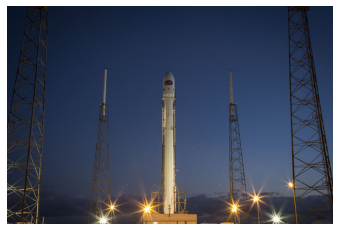

In [37]:
# Flip the image horizontally
hflip_rocket = np.fliplr(rocket)
show_image(hflip_rocket)

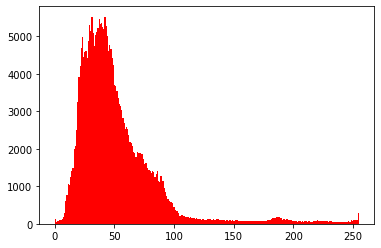

In [40]:
# Histograms for intensity and color analysis.
rrocket = rocket[:,:,0]
_ = plt.hist(rrocket.ravel(), bins=256, color='red')
plt.show()

# Thresholding

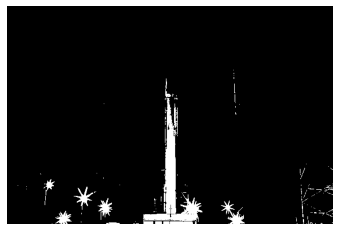

In [55]:
thresh = 127/256
binary = grey_rocket > thresh
show_image(binary, cmap='Greys_r')

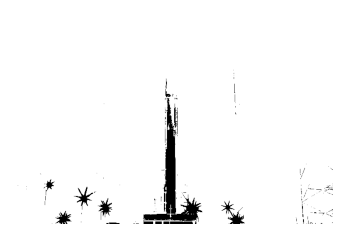

In [56]:
inv_binary = grey_rocket <= thresh
show_image(inv_binary, cmap='Greys_r')

<Figure size 1440x720 with 0 Axes>

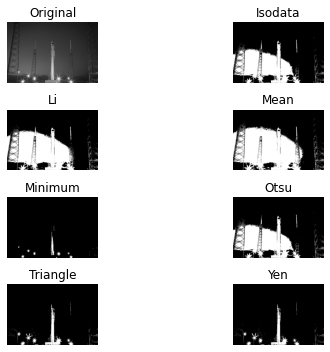

<Figure size 1440x720 with 0 Axes>

In [62]:
fig, ax = try_all_threshold(grey_rocket, verbose=False)
plt.figure(figsize=(20,10))

How to choose optimal threshold value?

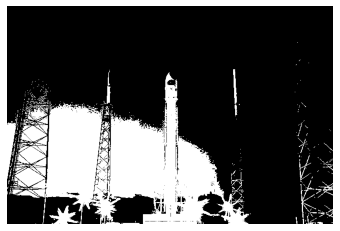

In [66]:
thresh = threshold_otsu(grey_rocket)
binary2 = grey_rocket > thresh
show_image(binary2, cmap='Greys_r')

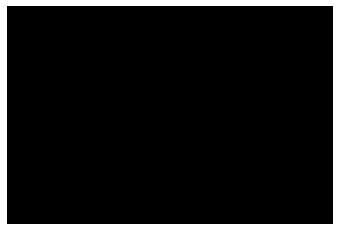

In [71]:
# This works well for example for texts.
local_thresh = threshold_local(grey_rocket, block_size=161, offset=40)
binary_local = grey_rocket > local_thresh
show_image(binary_local, 'Greys_r')

# Filters

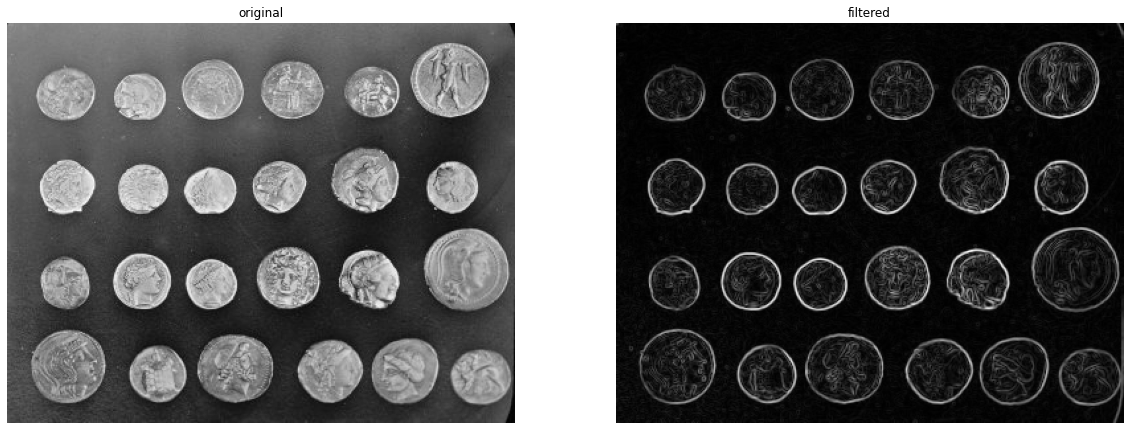

In [83]:
coins = data.coins()
gcoins = color.rgb2gray(coins)
edge_coins = sobel(gcoins)
plot_comparison(coins, edge_coins, size=(20,10))

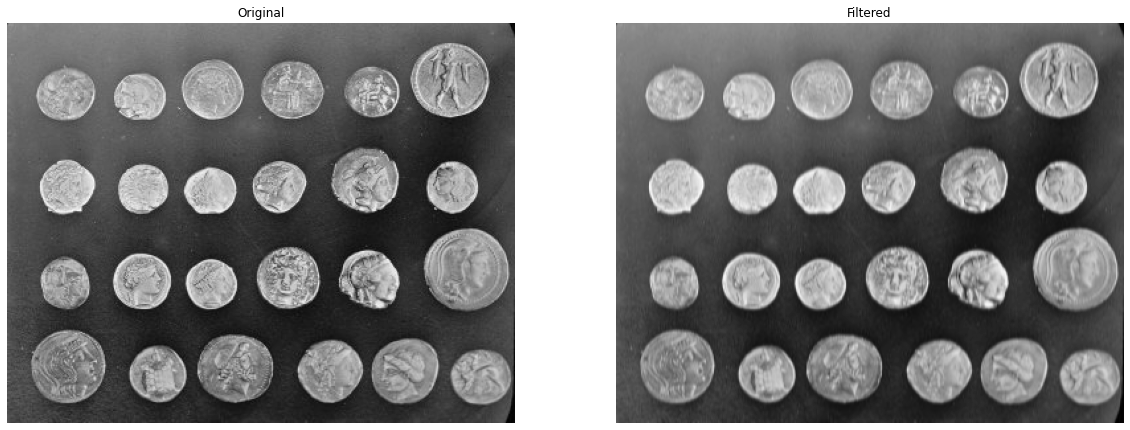

In [123]:
# Apply Blur
ggcoins = gaussian(coins, multichannel=True)
plot_comparison(coins, ggcoins)

Contrast is the difference between the maximum and minimum pixel intensity

Enhancement:

1. Histogram Equalization --> Spreads out the most frequent intensity values
2. Adaptive histogram equalization
3. Contrast limited Adaptive Histogram Equalization

In [124]:
lc = plt.imread('low_contrast.png')
eq_hist = exposure.equalize_hist(lc)
adapt_eq = exposure.equalize_adapthist(lc, clip_limit=0.03)
gamma = exposure.adjust_gamma(lc) # Just to try out comparison function

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


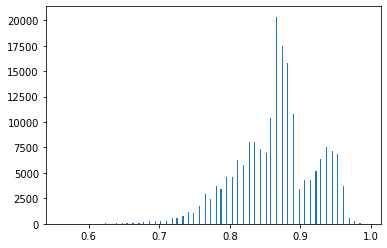

In [127]:
_ = plt.hist(lc.ravel(), bins=256)
plt.show()

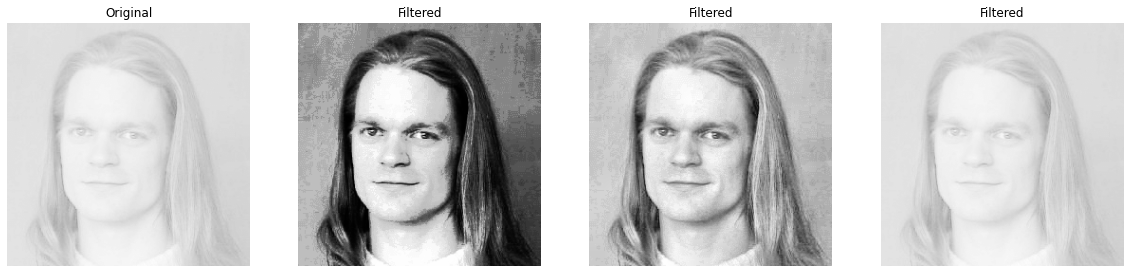

In [126]:
plot_comparison(lc, eq_hist, adapt_eq, gamma)

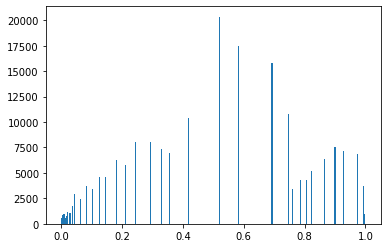

In [128]:
_ = plt.hist(eq_hist.ravel(), bins=256)
plt.show()

increased the contrast of the image using an algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than the rest of the image.

# Transformations

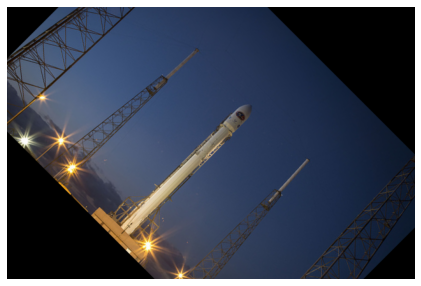

In [130]:
rot_rocket = rotate(rocket, -45)
show_image(rot_rocket)

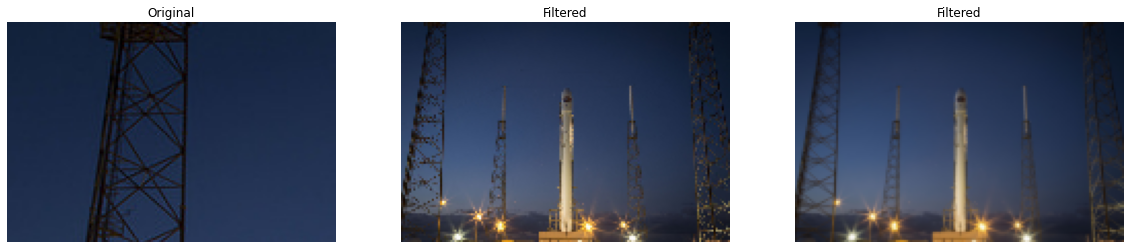

In [135]:
scale_rocket = rescale(rocket, 1/4, anti_aliasing=False, multichannel=True)
scale_rocket_aliased = rescale(rocket, 1/4, anti_aliasing=True, multichannel=True)
plot_comparison(rocket, scale_rocket, scale_rocket_aliased)

(427, 640, 3) (1200, 600, 3)


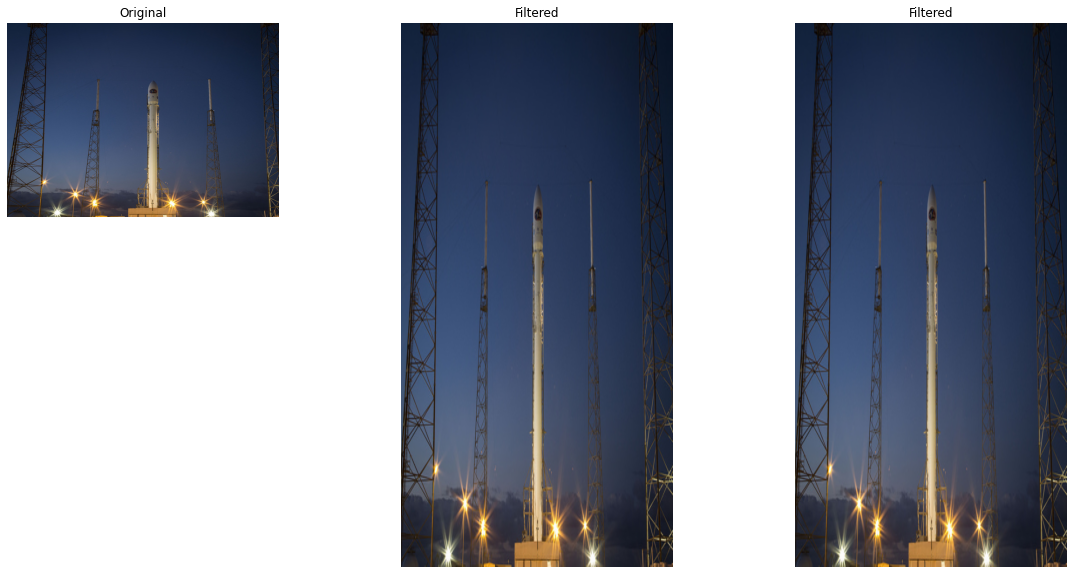

In [142]:
resize_rocket = resize(rocket, (1200,600), anti_aliasing=False)
resize_rocket_aliased = resize(rocket, (1200,600), anti_aliasing=True)
print(rocket.shape, resize_rocket.shape)
plot_comparison(rocket, resize_rocket, resize_rocket_aliased)

# Morphology

Try to remove imperfections from form and texture.

1. Dilation --> adds pixels to the boundaries of objects
2. Erosion --> removes pixels on object boundaries

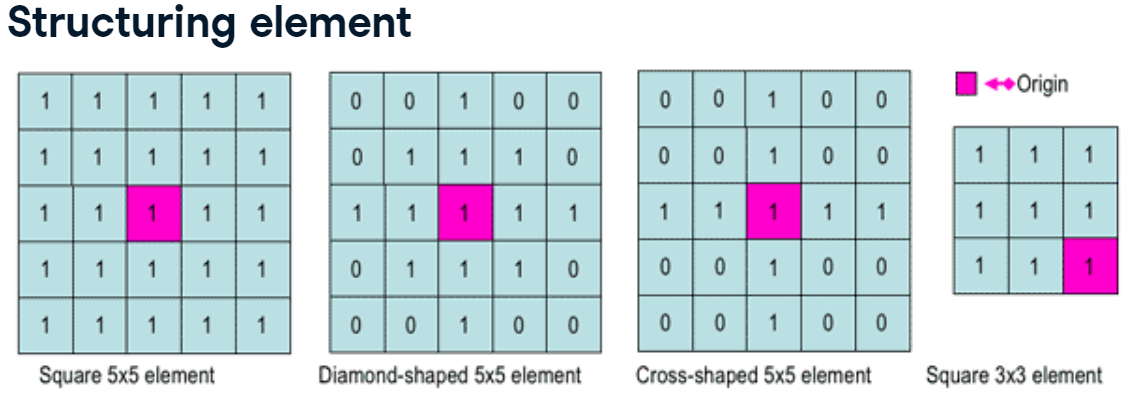

In [149]:
square = morphology.square(4)
rectangle = morphology.rectangle(12, 6)
print(square)
print('')
print(rectangle)

[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]


In [154]:
horse = data.horse()
eroded_horse = morphology.binary_erosion(horse, selem=rectangle)
eroded_horse2 = morphology.binary_erosion(horse)

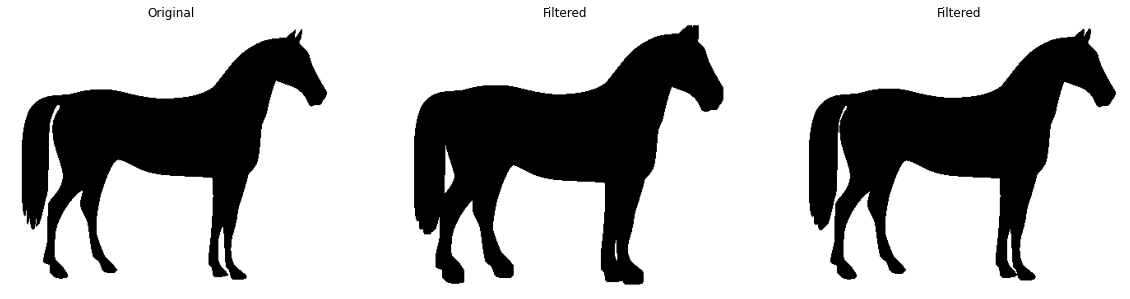

In [155]:
plot_comparison(horse, eroded_horse, eroded_horse2)

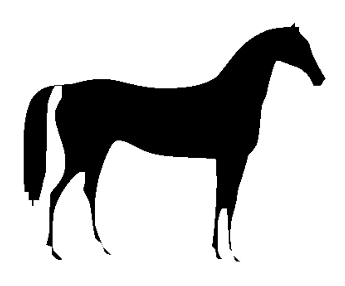

In [160]:
dilated_horse2 = morphology.binary_dilation(horse, rectangle)
show_image(dilated_horse2, cmap='Greys_r')

# Image Restoration

In [168]:
# This is an example, since this mask has to be made case by case according to the corrupted areas.
def get_mask(img):
  # Tensor of zeros with height and width of image, without channels.
  mask = np.zeros(img.shape[:-1])

  mask[101:106, 0:240] = 1

  mask[152:154, 0:60] = 1
  mask[153:155, 60:100] = 1
  mask[154:156, 100:120] = 1
  mask[155:156, 0:60] = 1

  mask[212:217, 0:150] = 1
  mask[217:222, 150:256] = 1
  return mask

In [184]:
def apply_mask(img):
  img2 = img
  img2[101:106, 0:240] = 0

  img2[152:154, 0:60] = 0
  img2[153:155, 60:100] = 0
  img2[154:156, 100:120] = 0
  img2[155:156, 0:60] = 0

  img2[212:217, 0:150] = 0
  img2[217:222, 150:256] = 0
  return img2

In [ ]:
cat = data.cat()

In [187]:
corrupted = apply_mask(cat)
mask = get_mask(corrupted)
restored_cat = inpaint.inpaint_biharmonic(corrupted, mask, multichannel=True)

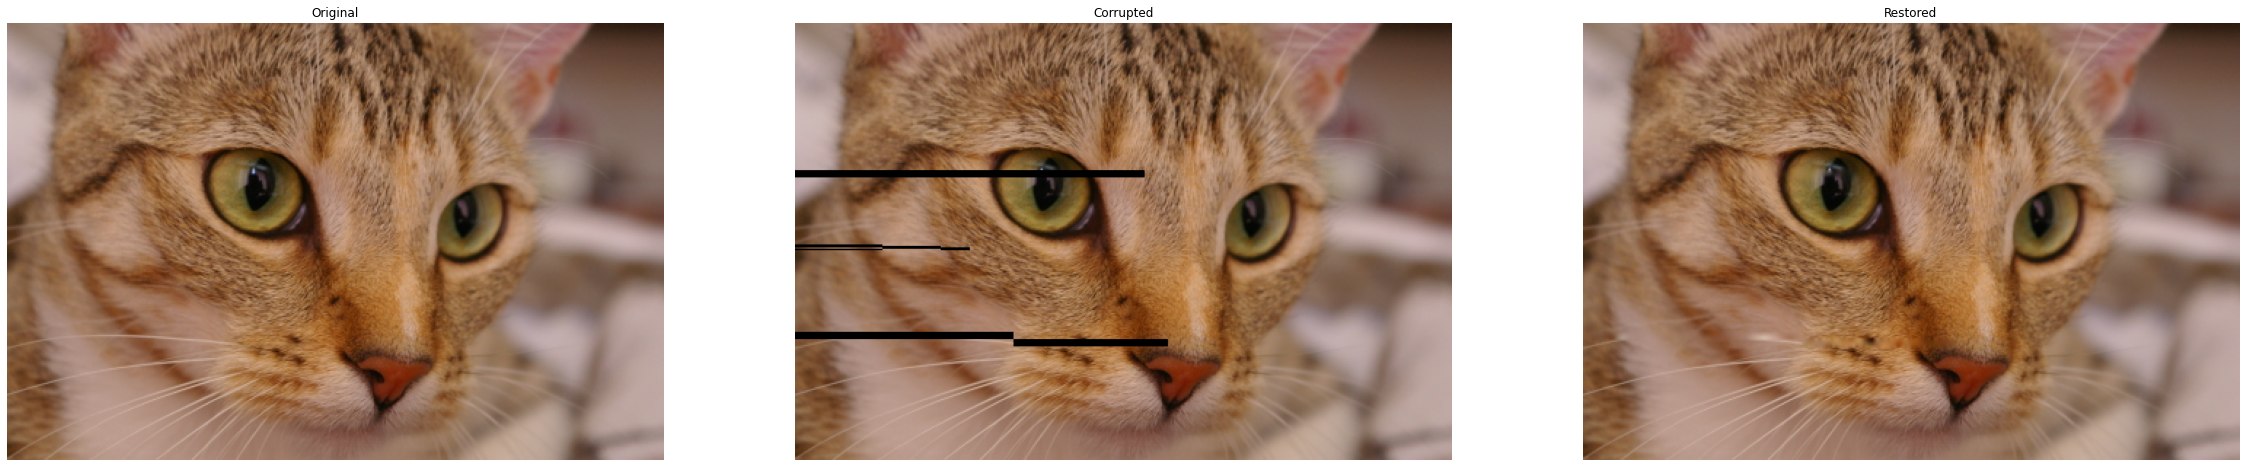

In [194]:
plot_comparison(cat, corrupted, restored_cat, titles=['Original', 'Corrupted', 'Restored'], size=(40,20))